![RFCAN](logo.png "RFCAN_LOGO")

In [ ]:
from codes_RF.prep import PREP

box = [55, 85, -105, -75]
radius =[30, 100]
mag = [5.5, 10.0]
events = [2000, 2030]
year = 3 #years of data

In [ ]:
PREP.preparation(box, radius, mag, events, year, verbose=False)

### Downloading RAW_WFs

To minimize the time spent on downloading from NRCAN, you have the option to specify which networks you want to download from their web server. Simply set nrcan=True to activate downloading from this source.
```
DL.comprehensive_download(NET1, NET2, ..., nrcan=True)
```



In [ ]:
from codes_RF.prep import DL
DL.comprehensive_download("X5","PO", nrcan=True)

### Creating RFs

In [ ]:
from codes_RF.prep import RF
list = RF.mk_rf(filters=[0.05,0.5])

### Manual QC

you can analyze your data set by filtering some part and look at the results

In [5]:
from codes_RF.prep import QC
QC.preview(filters=["sta_code-eq-YRTN","rf_quality-eq-1"], data_type="rf", preview_type="plot")

here you can do QC by examining the RFs and the corresponding RAW_WFs one-on-one

In [ ]:
from codes_RF.prep import QC
QC.manual_quality()

### Automatic QC by DeepQCRF

Doing QC using DeepQCRF is also possible, and you just need to use the following command and also filter your dataset by test_set_keywords:


In [ ]:
from codes_RF.prep import QC

test_set_keywords = ["net_code-eq-X5", "ev_mag-gt-5.0"]
new_df = QC.quality_pred(test_set_keywords)

### Visualizing RFs

Setting your input stations and the bin size for the RFs

In [1]:
from codes_RF.viz import viz
import pandas as pd

# sta_list = list(pd.read_csv("inv/all_stations.csv")["all"])
# print(sta_list)
sta_list = ['YRTN']

hist_bin = 20

Dataframe has been updated
slow and baz have been added to the dataframe
Plotting the histogram of baz for each station ...
Number of waveforms for YRTN is 14


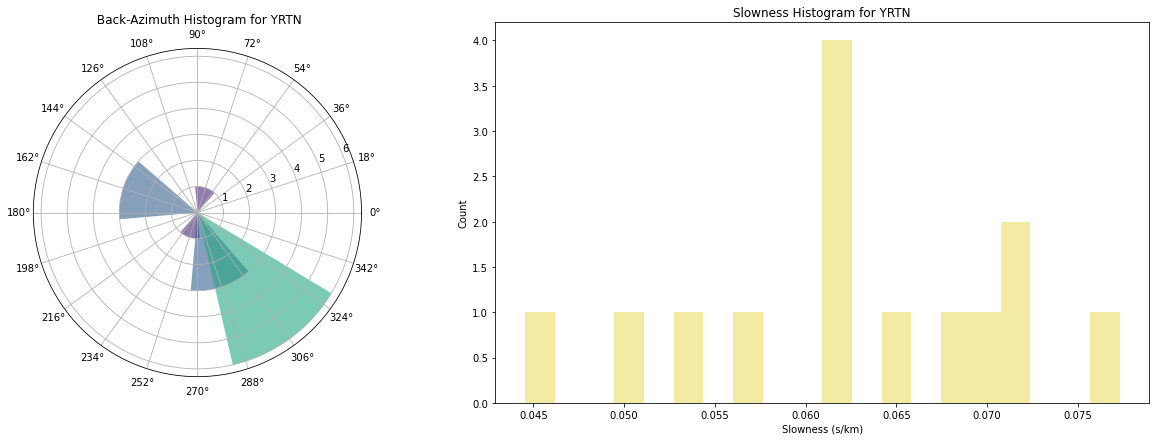

Plotting the slow section for each station ...


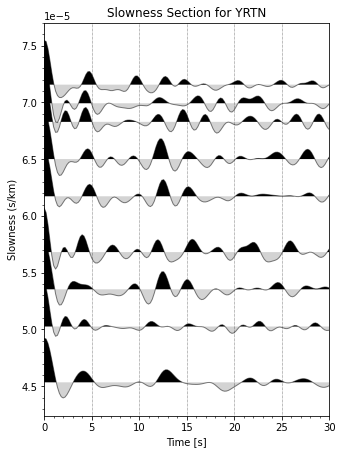

Plotting the baz section for each station ...


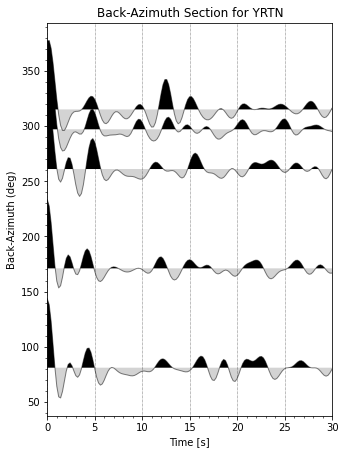

In [2]:
my_proj = viz(sta_list, hist_bin, using_pred=True)   #create a viz object
my_proj.distribution_hist()         #plot distribution histogram for baz and slow
my_proj.plot_section(type="slow")   #plot section for slow
my_proj.plot_section(type="baz")    #plot section for baz

## H-k Stacking

! below station ILON is in both CN and PO networks, so it uses both networks to stack the 

I removed station **AKVQ** from the list cause there is only two waveforms for this station

In [ ]:
from codes_RF.hk import HKCan

path_file = "DATA/waveforms_list.csv"

#temp#temp#temp
import numpy as np
import pandas as pd
stations = pd.read_csv(path_file)["sta_code"].unique()
stations = np.array(stations)
stations = np.sort(stations)
stations = np.delete(stations, np.where(stations == "AKVQ"))
stations = np.delete(stations, np.where(stations == "SNKN"))
stations = np.delete(stations, np.where(stations == "KJKQ"))
stations = np.delete(stations, np.where(stations == "MRYN"))
stations = np.delete(stations, np.where(stations == "IVKQ"))
#TEMPORARY STATIONS
stations = ["CRLN","CTSN",'MANN',"MARN", "DORN", "NOTN", "SHWN", "SHMN"]
print(stations)

for sta in stations:
    print(sta, "++++++++++++++++++++++++++++++++++++++++++++++")
    hkcan = HKCan(path_file, sta, weights=[.5, 2., -1.])#weights=weights[stations.index(sta)])
    hkcan.hk(vp=6.5)
    # hkcan.hk_change_param(weights=[3,1,-1], plot=True, auto_optimization=True)   #weights[stations.index(sta)], plot=True, auto_optimization=True)
    

In [ ]:
from codes_RF.rfpy_pkg.harmonics import Harmonics
import pandas as pd
import obspy
import numpy as np

# # stations = ["SHWN", "SHMN", "MARN", "MANN", "DORN", "NOTN", "CRLN", "CTSN"]
# # stations = ["SHWN", "SHMN", "MARN", "MANN", "DORN", "NOTN", "CRLN", "CTSN", "AXF", "CNF", "IBFB", "IBFE", "TQF", "MISB1", "MISB2", "PVB1", "PVB2", "BLKN", "EUNU", "FCC", "ILON", "POIN", "RES", "SAKN", "AKVQ", "AP3N", "ARVN", "BULN", "GIFN", "IGLN", "INUQ", "IVKQ", "JSON", "KUGN", "LAIN", "MCMN", "MRYN", "NUNN", "QILN", "SEDN", "SMLN", "SNKN", "SNQN", "SRLN", "STLN", "WAGN", "YBKN", "YRTN"]
stations = pd.read_csv("DATA/waveforms_list.csv")["sta_code"].unique()

#temp#temp#temp

# stations = np.delete(stations, np.where(stations == "AKVQ"))
# stations = np.delete(stations, np.where(stations == "SNKN"))
# stations = np.delete(stations, np.where(stations == "KJKQ"))
# stations = np.delete(stations, np.where(stations == "MRYN"))


for sta in stations:

    print(f"==================== {sta} ====================")
    list_df = pd.read_csv("DATA/waveforms_list.csv")
    list_sta = list_df[(list_df.sta_code == sta) & (list_df.rf_quality == 1)]

    #reading all waveforms R and T
    rfR = obspy.Stream()
    rfT = obspy.Stream()

    for i in range(len(list_sta)):
        file_name = list_sta.file_name.iloc[i]
        path = f"DATA/RF/{file_name}.pkl"
        wf = obspy.read(path)
        rfR += wf.select(channel = "RFR")
        rfT += wf.select(channel = "RFT")

    rfR.filter('bandpass', freqmin = 0.05, freqmax = 0.5, corners = 4, zerophase = True)
    rfT.filter('bandpass', freqmin = 0.05, freqmax = 0.5, corners = 4, zerophase = True)

    harmonics = Harmonics(rfR, rfT)


    harmonics.dcomp_find_azim()

    print(f"{harmonics.azim = }")
    print(f"Number of events = {len(list_sta)}")

    harmonics.plot(scale = 4, title=f"{sta} - {harmonics.azim:.0f}°")

In [ ]:
from codes_RF.rfpy_pkg.harmonics import Harmonics
import pandas as pd
import obspy
import numpy as np



# #Profile A-A'
# dist = [0,  286,  325,  364,  398, 1061, 1455, 1482, 1646, 1708, 1990, 2214]
# stations= ["ARVN", "YRTN", "MCMN", "JOSN", "SEDN", "QILN", "SRLN", "LAIN", "ILON", "GIFN", "MARN", "POIN"]

# # Profile B-B'
# dist = [701, 260, 751, 181, 196]
# dist = np.cumsum(dist)
# stations= ["INUQ", "CTSN", "SHWN", "KUGN", "SMLN"]

# Profile C-C'
dist = [0, 1656, 465, 250]
dist = np.cumsum(dist)
stations= ["RES", "CNF", "TQF", "MCF"]

# #Profile D-D'
# dist = [0, 276, 489, 553, 876, 981, 1130]
# stations= ["FCC", "ARVN", "YRTN", "MCMN", "BULN", "STLN", "SMLN"]

# #Profile E-E'
# dist = [0, 181, 11, 28, 11, 307, 47, 44, 39, 145, 75, 85]
# dist = np.cumsum(dist)
# stations= ["BLKN", "MCMN", "JOSN", "SEDN", "QILN", "SHWN", "SHMN", "CRLN", "CTSN", "MANN", "NOTN", "DORN"]

Az = obspy.Stream() # for storing all A(z) components

for sta, dist in zip(stations, dist):

    print(f"==================== {sta} ====================")
    list_df = pd.read_csv("DATA/waveforms_list.csv")
    list_sta = list_df[(list_df.sta_code == sta) & (list_df.rf_quality == 1)]

    #reading all waveforms R and T
    rfR = obspy.Stream()
    rfT = obspy.Stream()

    for i in range(len(list_sta)):
        file_name = list_sta.file_name.iloc[i]
        path = f"DATA/RF/{file_name}.pkl"
        wf = obspy.read(path)
        rfR += wf.select(channel = "RFR")
        rfT += wf.select(channel = "RFT")

    rfR.filter('bandpass', freqmin = 0.05, freqmax = 0.5, corners = 4, zerophase = True)
    rfT.filter('bandpass', freqmin = 0.05, freqmax = 0.4, corners = 4, zerophase = True)

    harmonics = Harmonics(rfR, rfT)


    harmonics.dcomp_find_azim()

    print(f"{harmonics.azim = }")
    print(f"Number of events = {len(list_sta)}")

    # harmonics.plot(scale = 4, title=f"{sta} - {harmonics.azim:.0f}°")
    hstream = harmonics.hstream[0]
    hstream.stats.distance = dist * 1000
    Az = Az + harmonics.hstream[0]

#plotting the A(z) components
starttime = Az[0].stats.starttime
for i, tr in enumerate(Az):
    tr.stats.starttime = starttime
    Az[i] = tr
Az.plot(type="section", fillcolors=("red","blue"), time_down=True, horizontal=True, scale=0.5, title="A(z) components", recordlength=25)
import matplotlib.pyplot as plt
plt.show()

In [ ]:
#my simple hk

freq = 5.
vp = 6.5
H = [15, 60]
K = [1.4, 2.5]
resolution = 20
h_inc = 1 / resolution
k_inc = .02 / resolution
weights = [1, 1, 2]

tr = Az[2]

#empty matrices
Ps_mat = np.zeros((len(np.arange(K[0], K[1], k_inc)), len(np.arange(H[0], H[1], h_inc))))
Pss_mat = np.zeros((len(np.arange(K[0], K[1], k_inc)), len(np.arange(H[0], H[1], h_inc))))
Pps_mat = np.zeros((len(np.arange(K[0], K[1], k_inc)), len(np.arange(H[0], H[1], h_inc))))


def funcPs(h, k, vp):
    vs = vp/k
    return h * (np.sqrt(vs**-2) - np.sqrt(vp**-2))

def funcPps(h, k, vp):
    vs = vp/k
    return h * (np.sqrt(vs**-2) + np.sqrt(vp**-2))

def funcPss(h, k, vp):
    vs = vp/k
    return h * 2 * np.sqrt(vs**-2)

for h in np.arange(H[0], H[1], h_inc):
    for k in np.arange(K[0], K[1], k_inc):
        tps = int(funcPs(h, k, vp) * freq)
        val = tr.data[tps]
        Ps_mat[int((k-K[0])/k_inc), int((h-H[0])/h_inc)] = val

for h in np.arange(H[0], H[1], h_inc):
    for k in np.arange(K[0], K[1], k_inc):
        tps = int(funcPps(h, k, vp) * freq)
        val = tr.data[tps]
        Pps_mat[int((k-K[0])/k_inc), int((h-H[0])/h_inc)] = val

for h in np.arange(H[0], H[1], h_inc):
    for k in np.arange(K[0], K[1], k_inc):
        tps = int(funcPss(h, k, vp) * freq)
        val = tr.data[tps]
        Pss_mat[int((k-K[0])/k_inc), int((h-H[0])/h_inc)] = val

#normalize all matrices between 0 and 1
Ps_mat = (Ps_mat - Ps_mat.min()) / (Ps_mat.max() - Ps_mat.min())
Pps_mat = (Pps_mat - Pps_mat.min()) / (Pps_mat.max() - Pps_mat.min())
Pss_mat = -(Pss_mat - Pss_mat.min()) / (Pss_mat.max() - Pss_mat.min())

import matplotlib.pyplot as plt
# subplots 2 by 2
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].imshow(Ps_mat, extent=[H[0], H[1], K[1], K[0]], aspect="auto")
axs[0, 0].invert_yaxis()
axs[0, 0].set_title("Ps")
axs[0, 1].imshow(Pps_mat, extent=[H[0], H[1], K[1], K[0]], aspect="auto")
axs[0, 1].invert_yaxis()
axs[0, 1].set_title("Pps")
axs[1, 0].imshow(Pss_mat, extent=[H[0], H[1], K[1], K[0]], aspect="auto")
axs[1, 0].invert_yaxis()
axs[1, 0].set_title("Pss")
axs[1, 1].imshow(Ps_mat * weights[0] + Pps_mat * weights[1] + Pss_mat * weights[2], extent=[H[0], H[1], K[1], K[0]], aspect="auto")
axs[1, 1].invert_yaxis()
axs[1, 1].set_title("Sum")
#set title for the figure
fig.suptitle(tr.stats.station)

plt.show()

In [ ]:
# Find the maximum stacking amplitude
S = Ps_mat * weights[0] + Pps_mat * weights[1] + Pss_mat * weights[2]
S_max = np.max(S)
k_max, h_max = np.unravel_index(np.argmax(S), S.shape)
h_max = H[0] + h_max * h_inc
k_max = K[0] + k_max * k_inc
print(f"Maximum stacking amplitude at h={h_max:.2f}, k={k_max:.2f}")
# Define confidence threshold
confidence_level = 0.95  # e.g., 95%
S_threshold = S_max * confidence_level
H_mat = np.arange(H[0], H[1], h_inc)
K_mat = np.arange(K[0], K[1], k_inc)

# Plot the contour
plt.figure(figsize=(8, 6))
contour = plt.contour(H_mat, K_mat, S, levels=[S_max * confidence_level], colors='red')
# contour = plt.contour(H_mat, K_mat, S, levels=[S_max * 0.8], colors='purple')
plt.contourf(H_mat, K_mat, S, levels=10, cmap='viridis')
plt.scatter(h_max, k_max, color='white', label=f'Max: h={h_max:.2f}, k={k_max:.2f}')
plt.colorbar(label='Stacking Amplitude')
plt.xlabel('Moho Depth (h)')
plt.ylabel('Vp/Vs Ratio (k)')
plt.legend()
plt.title('Confidence Interval for HK-Stacking')
plt.show()

# Extract contour coordinates (error bounds calculation)
contour_paths = contour.collections[0].get_paths()
bounds = [path.vertices for path in contour_paths]

# Compute error ranges from contour vertices
h_bounds = [vertex[0] for path in bounds for vertex in path]
k_bounds = [vertex[1] for path in bounds for vertex in path]
h_error = (min(h_bounds), max(h_bounds))
k_error = (min(k_bounds), max(k_bounds))

print(f"Confidence interval for h: {h_error}")
print(f"Confidence interval for k: {k_error}")

In [ ]:
np.arctan(4/190) * 180 / np.pi

In [ ]:
76.88/3.08